# Active Learning Meetup

Autor: Luiz Matias

29 de outubro de 2020

## Introdução
Hoje em dia é fácil conseguir dados. Porém, conseguir dados rotulados nem tanto. O processo de rotulação pode ser caro e demorado. Nesta situação, como podemos otimizar esse trabalho e escolher os dados certos para rotular? Como garantir que a amostra de dados a serem rotulados não seja redundante ou represente bem a distribuição dos dados como um todo?

Para isso, existe uma técnica chamada Active Learning. O diagrama de como é feito essa técnica é mostrado a seguir. O princípio é escolher de forma inteligente a melhor amostra a ser rotulada com base no seu modelo e nas suas incertezas.

<img src="../img/diagram.png" align="center"/>

Como escolher os melhores dados a serem rotulados? Ao pegar uma amostra em uma região incerta (pode ser visto em um espaço vetorial mais pra frente), certamente vamos obter mais informações do que pegar uma amostra aleatória. Isso é chamado de pool-based sampling. A ideia é pegar os dados que estão em uma região incerta e fazermos a rotulação neles. Mas como pegar esses dados na região incerta? Para isso vamos adotar a estratégia de Uncertainty Sampling. 

Essa estratégia é mensurada pela fórmula:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>U</mi>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mn>1</mn>
  <mo>&#x2212;<!-- − --></mo>
  <mi>P</mi>
  <mo stretchy="false">(</mo>
  <mrow class="MJX-TeXAtom-ORD">
    <mover>
      <mi>x</mi>
      <mo stretchy="false">&#x005E;<!-- ^ --></mo>
    </mover>
  </mrow>
  <mrow class="MJX-TeXAtom-ORD">
    <mo stretchy="false">|</mo>
  </mrow>
  <mi>x</mi>
  <mo stretchy="false">)</mo>
</math>

onde x é a instância a ser prevista e x ^ é a previsão mais provável. Ou seja, ele pega uma amostra com a menor probabilidade de pertencer a determinada classe. (a mais incerta!). Para saber mais, acesse a <a href="https://modal-python.readthedocs.io/en/latest/content/query_strategies/uncertainty_sampling.html" target="_blank">documentação do modAL</a>.

### Importanto Bibliotecas

In [141]:
import pandas as pd
#from src.processing_functions import preprocessing, dataframe_text_feature
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn import pipeline, feature_extraction
import numpy as np
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.model_selection import train_test_split
import __init__
from src.plot_functions import plot_distribution, plot_class_predictions, plot_decision_boundary, plot_performance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Criando um dataset XOR

In [142]:
rng = np.random.RandomState(0)
X_raw = rng.randn(200, 2)
y_raw = np.logical_xor(X_raw[:, 0] > 0, X_raw[:, 1] > 0).astype(np.int)
rng_test = np.random.RandomState(42)
X_test = rng_test.randn(50, 2)
y_test = np.logical_xor(X_test[:, 0] > 0, X_test[:, 1] > 0).astype(np.int)

In [143]:
# Isolate our examples for our labeled dataset.
np.random.seed(0)
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=5)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

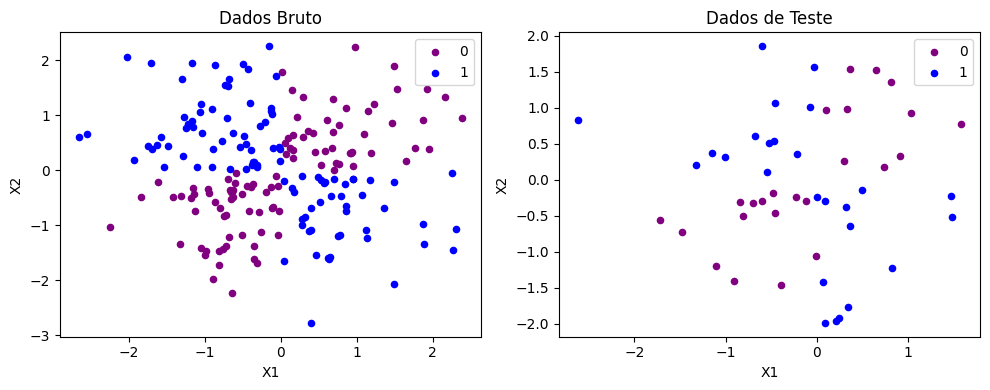

In [144]:
plot_distribution(X_raw, y_raw, X_test, y_test)

In [145]:
# Specify our core estimator along with it's active learning model.
svm = SVC(probability=True, random_state=0)
learner = ActiveLearner(estimator=svm, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

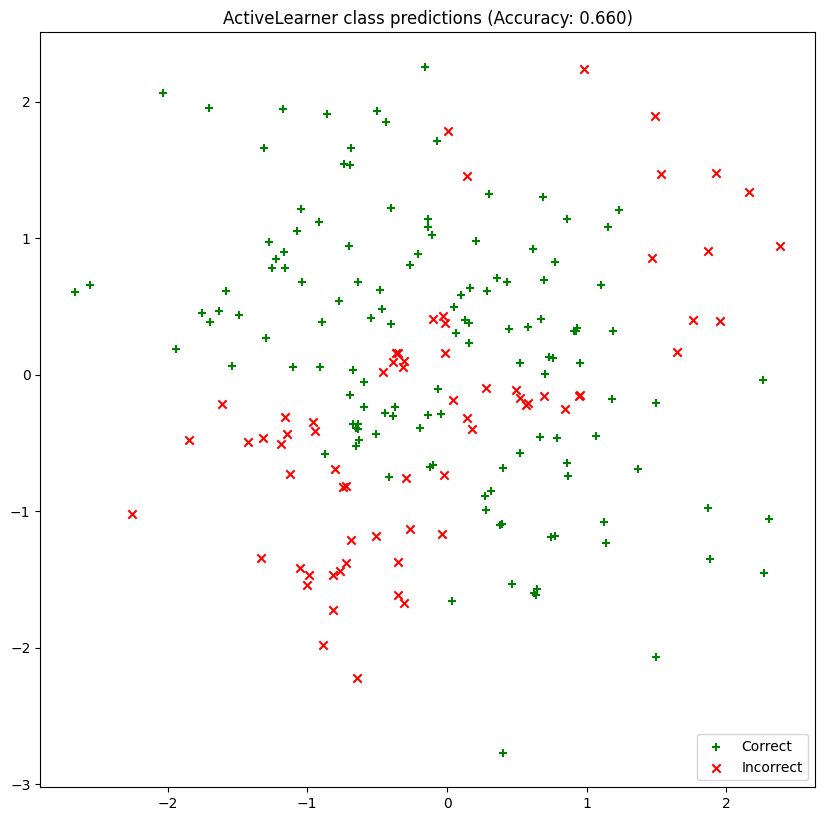

In [146]:
plot_class_predictions(X_raw, y_raw, learner)

In [147]:
N_QUERIES = 94
unqueried_score = learner.score(X_raw, y_raw)
performance_history = [unqueried_score]

X_pool_uncert = X_pool.copy()
y_pool_uncert = y_pool.copy()
from sklearn.base import clone

lr2 = clone(learner, safe=True)
# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
    query_index, query_instance = lr2.query(X_pool_uncert)

    # Teach our ActiveLearner model the record it has requested.
    X_act, y_act = X_pool_uncert[query_index].reshape(1, -1), y_pool_uncert[query_index].reshape(1, )
    lr2.teach(X=X_act, y=y_act)

    # Remove the queried instance from the unlabeled pool.
    X_pool_uncert, y_pool_uncert = np.delete(X_pool_uncert, query_index, axis=0), np.delete(y_pool_uncert, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = lr2.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.7100
Accuracy after query 2: 0.7750
Accuracy after query 3: 0.6350
Accuracy after query 4: 0.6600
Accuracy after query 5: 0.6350
Accuracy after query 6: 0.8050
Accuracy after query 7: 0.6200
Accuracy after query 8: 0.8100
Accuracy after query 9: 0.8100
Accuracy after query 10: 0.8350
Accuracy after query 11: 0.7800
Accuracy after query 12: 0.8050
Accuracy after query 13: 0.7500
Accuracy after query 14: 0.8050
Accuracy after query 15: 0.8300
Accuracy after query 16: 0.8350
Accuracy after query 17: 0.8750
Accuracy after query 18: 0.8650
Accuracy after query 19: 0.8650
Accuracy after query 20: 0.8650
Accuracy after query 21: 0.8750
Accuracy after query 22: 0.8700
Accuracy after query 23: 0.9000
Accuracy after query 24: 0.9050
Accuracy after query 25: 0.9000
Accuracy after query 26: 0.8950
Accuracy after query 27: 0.8950
Accuracy after query 28: 0.9150
Accuracy after query 29: 0.9000
Accuracy after query 30: 0.9350
Accuracy after query 31: 0.9250
Accuracy after qu

In [149]:
svm.fit(X_train, y_train)
predictions = svm.predict(X_raw)
is_correct = (predictions == y_raw)

In [150]:
N_QUERIES = 94
unqueried_score_random = svm.score(X_raw, y_raw)
performance_history_random = [unqueried_score_random]

X_pool_random = X_pool.copy()
y_pool_random = y_pool.copy()

X_train_new = X_train.copy()
y_train_new = y_train.copy()
# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).

for index in range(N_QUERIES):
    np.random.seed(1234)
    query_index = np.random.randint(low=0, high=X_pool_random.shape[0])
    query_instance = [X_pool[query_index].tolist()]
    # Teach our ActiveLearner model the record it has requested.
    X_random, y_random = X_pool_random[query_index].reshape(1, -1), y_pool_random[query_index].reshape(1, )

    X_train_new = np.concatenate((X_train_new, X_random))
    y_train_new = np.concatenate((y_train_new, y_random))
    
    svm.fit(X_train_new, y_train_new)
    

    # Remove the queried instance from the unlabeled pool.
    X_pool_random, y_pool_random = np.delete(X_pool_random, query_index, axis=0), np.delete(y_pool_random, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = svm.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history_random.append(model_accuracy)

Accuracy after query 1: 0.6350
Accuracy after query 2: 0.6250
Accuracy after query 3: 0.5900
Accuracy after query 4: 0.5950
Accuracy after query 5: 0.5850
Accuracy after query 6: 0.7050
Accuracy after query 7: 0.7300
Accuracy after query 8: 0.7200
Accuracy after query 9: 0.7250
Accuracy after query 10: 0.7400
Accuracy after query 11: 0.7550
Accuracy after query 12: 0.7550
Accuracy after query 13: 0.7600
Accuracy after query 14: 0.7400
Accuracy after query 15: 0.7900
Accuracy after query 16: 0.7900
Accuracy after query 17: 0.7850
Accuracy after query 18: 0.7900
Accuracy after query 19: 0.7400
Accuracy after query 20: 0.7900
Accuracy after query 21: 0.7900
Accuracy after query 22: 0.7800
Accuracy after query 23: 0.7700
Accuracy after query 24: 0.7800
Accuracy after query 25: 0.7800
Accuracy after query 26: 0.8400
Accuracy after query 27: 0.8350
Accuracy after query 28: 0.8450
Accuracy after query 29: 0.8400
Accuracy after query 30: 0.8400
Accuracy after query 31: 0.8400
Accuracy after qu

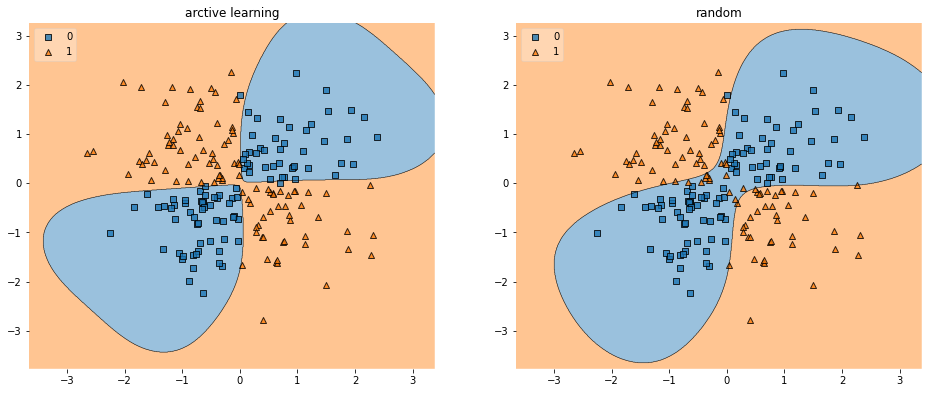

In [151]:
plot_decision_boundary(X_raw, y_raw, lr2, svm)

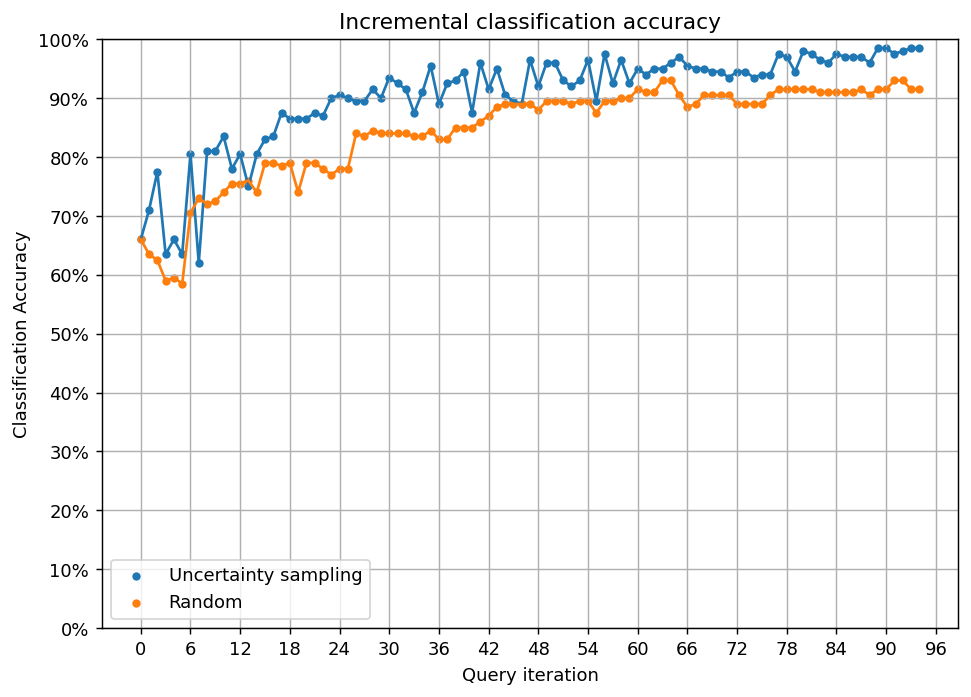

In [152]:
plot_performance(performance_history_random, performance_history)

In [153]:
lr2.score(X_test, y_test)

0.98

In [154]:
svm.score(X_test, y_test)

0.92

## Sources

- https://gspread.readthedocs.io/en/latest/
- http://burrsettles.com/pub/settles.activelearning.pdf
- https://modal-python.readthedocs.io/en/latest/
- https://medium.com/towards-artificial-intelligence/how-to-use-active-learning-to-iteratively-improve-your-machine-learning-models-1c6164bdab99
- https://medium.com/@tivadar.danka/how-to-use-unlabelled-data-to-get-more-training-data-218f300fffe4
- https://www.youtube.com/watch?v=0efyjq5rWS4
- https://arxiv.org/pdf/1805.00979.pdf
- https://towardsdatascience.com/active-learning-tutorial-57c3398e34d
- https://github.com/modAL-python/modAL